# Лабораторная работа 4. 
--------
+ **Тема:** RFM-кластеризация покупателей (по CRISP-DM)
+ **Выполнил:** Маковеев Никита Владимирович.
------


In [106]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
random_state = 97

## Понимание данных

### Загрузка данных и структура таблицы


In [107]:
data = pd.read_csv('customer_segmentation_project.csv', encoding='ISO-8859-1')


print("Размер данных:", data.shape)
print("\nТипы данных и наличие non-null:")
data.info()

data.sample(5)


Размер данных: (541909, 8)

Типы данных и наличие non-null:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
308018,563935,23068,ALUMINIUM STAMPED HEART,2,8/21/2011 16:24,2.49,15547.0,United Kingdom
534259,581142,22533,MAGIC DRAWING SLATE BAKE A CAKE,5,12/7/2011 13:38,0.42,14204.0,United Kingdom
228361,556926,21984,PACK OF 12 PINK PAISLEY TISSUES,2,6/15/2011 14:26,0.29,16324.0,United Kingdom
430587,573585,22282,12 EGG HOUSE PAINTED WOOD,2,10/31/2011 14:41,24.96,NaN,United Kingdom
83080,543281,48173C,DOORMAT BLACK FLOCK,1,2/6/2011 15:34,7.95,14606.0,United Kingdom


### Первичный обзор данных

In [108]:
print("Диапазон дат:", data['InvoiceDate'].min(), "до", data['InvoiceDate'].max())
print("Уникальных CustomerID:", data['CustomerID'].nunique())
print("Уникальных StockCode:", data['StockCode'].nunique())
print("Уникальных стран:", data['Country'].nunique())
print("\nТоп-5 стран по числу транзакций:")
print(data['Country'].value_counts().head())
print("\nПример кол-ва позиций в одном заказе (InvoiceNo=536365):")
print(data[data['InvoiceNo'] == '536365'].shape[0], "строк")
data[data['InvoiceNo'] == '536365'].head()


Диапазон дат: 1/10/2011 10:04 до 9/9/2011 9:52
Уникальных CustomerID: 4372
Уникальных StockCode: 4070
Уникальных стран: 38

Топ-5 стран по числу транзакций:
Country
United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Name: count, dtype: int64

Пример кол-ва позиций в одном заказе (InvoiceNo=536365):
7 строк


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Поиск пропусков и дубликатов


In [109]:
# Количество пропусков в каждом столбце
print(data.isna().sum())
# Удаление записей без CustomerID или Description
print("Удаляем записи с пустым CustomerID или Description...")
initial_rows = data.shape[0]
data = data.dropna(subset=['CustomerID', 'Description'])
print(f"Удалено строк с пустым CustomerID/Description: {initial_rows - data.shape[0]}")
# Поиск и удаление полных дубликатов
print("Ищем полные дубликаты...")
initial_rows = data.shape[0]
data = data.drop_duplicates()
print(f"Удалено полных дубликатов: {initial_rows - data.shape[0]}")
print("Размер данных после очистки:", data.shape)


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
Удаляем записи с пустым CustomerID или Description...
Удалено строк с пустым CustomerID/Description: 135080
Ищем полные дубликаты...
Удалено полных дубликатов: 5225
Размер данных после очистки: (401604, 8)


### Выбросы и аномалии

In [110]:
# Статистики Quantity и UnitPrice
print(data[['Quantity','UnitPrice']].describe(percentiles=[0.01,0.05,0.95,0.99]))
# Сколько транзакций с отрицательным Quantity (возвраты)?
print("Количество строк с Quantity < 0 (возвраты):", (data['Quantity'] < 0).sum())
# Сколько транзакций с ценой 0?
print("Количество строк с UnitPrice = 0 (бесплатно):", (data['UnitPrice'] == 0).sum())
# Пример очень больших Quantity
print("Топ-5 по Quantity:")
print(data.nlargest(5,
                    'Quantity')[['InvoiceNo','StockCode','Description','Quantity','UnitPrice']])

            Quantity      UnitPrice
count  401604.000000  401604.000000
mean       12.183273       3.474064
std       250.283037      69.764035
min    -80995.000000       0.000000
1%         -2.000000       0.210000
5%          1.000000       0.420000
50%         5.000000       1.950000
95%        36.000000       8.500000
99%       120.000000      15.000000
max     80995.000000   38970.000000
Количество строк с Quantity < 0 (возвраты): 8872
Количество строк с UnitPrice = 0 (бесплатно): 40
Топ-5 по Quantity:
       InvoiceNo StockCode                        Description  Quantity  \
540421    581483     23843        PAPER CRAFT , LITTLE BIRDIE     80995   
61619     541431     23166     MEDIUM CERAMIC TOP STORAGE JAR     74215   
502122    578841     84826     ASSTD DESIGN 3D PAPER STICKERS     12540   
421632    573008     84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS      4800   
206121    554868     22197               SMALL POPCORN HOLDER      4300   

        UnitPrice  
540421       2.0

## Подготовка данных

### Очистка: удаление выбросов

In [111]:
# Удалим транзакции с Quantity = 0 или UnitPrice = 0, если есть
initial_rows = data.shape[0]
data = data[(data['Quantity'] != 0) & (data['UnitPrice'] != 0)]
print(f"Удалено строк с Quantity=0 или UnitPrice=0: {initial_rows - data.shape[0]}")
# Проверим, сколько отрицательных Quantity осталось
print("Отрицательных Quantity осталось:", (data['Quantity'] < 0).sum())


Удалено строк с Quantity=0 или UnitPrice=0: 40
Отрицательных Quantity осталось: 8872


In [112]:
data[(data['Quantity'] < 0) & (~data['InvoiceNo'].str.startswith("C"))]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


Как видим все строки с возвратами имеют общую структуру, поэтому выбрососв мы тут не нашли.

### Создание признака TotalPrice.

In [113]:
data['TotalPrice'] = data['UnitPrice'] * data['Quantity']
# Контроль: средняя и суммарная выручка по данным после очистки
print("Средняя сумма по строке:", round(data['TotalPrice'].mean(), 2))
print("Общая сумма всех транзакций:", round(data['TotalPrice'].sum(), 2))


Средняя сумма по строке: 20.62
Общая сумма всех транзакций: 8278519.42


###  Формирование RFM-признаков.

In [114]:
# Преобразуем InvoiceDate в datetime, если еще не преобразован
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
# Определяем reference_date как день после последней даты в данных (чтобы последний день имел recency 0)
reference_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)
# Готовим агрегирование:
# Для Frequency используем только положительные транзакции (иначе возврат повысит Frequency, что неправильно)
sales_data = data[data['InvoiceNo'].str.startswith('C') == False]


rfm = sales_data.groupby('CustomerID').agg(
Recency=('InvoiceDate', lambda x: (reference_date - x.max()).days),
Frequency=('InvoiceNo', 'nunique')
).reset_index()
# Monetary считаем по ВСЕМ данным (с учетом возвратов)
monetary = data.groupby('CustomerID').agg(Monetary=('TotalPrice','sum')).reset_index()
# Объединяем таблицы
rfm = pd.merge(rfm, monetary, on='CustomerID', how='left').fillna({'Recency': np.nan, 'Frequency': 0, 'Monetary': 0})
print("Пример RFM для первых 5 клиентов:")
display(rfm.head(5))
print("Всего клиентов в RFM таблице:", rfm.shape[0])
print("Есть ли клиенты с отрицательным Monetary?", (rfm['Monetary'] < 0).any())

Пример RFM для первых 5 клиентов:


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,0.00
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


Всего клиентов в RFM таблице: 4338
Есть ли клиенты с отрицательным Monetary? True


###  Анализ распределений R, F, M и обработка выбросов

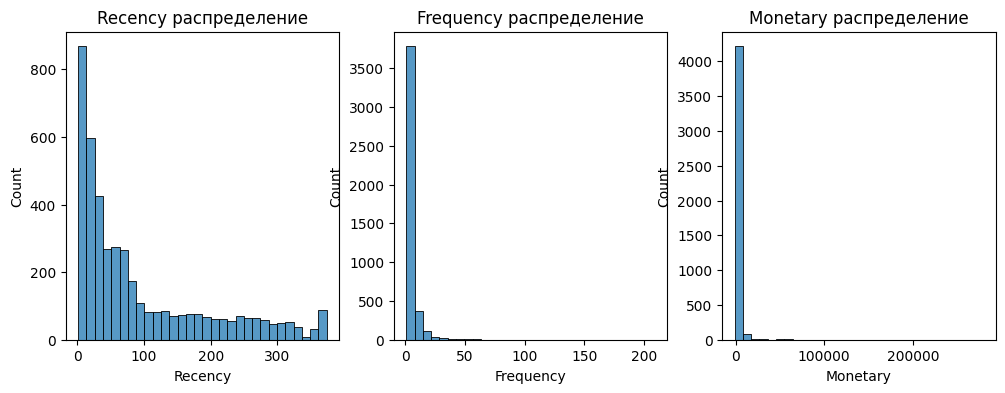

           Recency    Frequency       Monetary
count  4338.000000  4338.000000    4338.000000
mean     92.536422     4.272015    1910.772398
std     100.014169     7.697998    8248.237548
min       1.000000     1.000000   -1165.300000
50%      51.000000     2.000000     649.955000
95%     312.000000    13.000000    5619.928000
99%     369.000000    30.000000   17399.630300
max     374.000000   209.000000  279489.020000


In [115]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.histplot(rfm['Recency'], bins=30)
plt.title("Recency распределение")
plt.subplot(1,3,2)
sns.histplot(rfm['Frequency'], bins=30)
plt.title("Frequency распределение")
plt.subplot(1,3,3)
sns.histplot(rfm['Monetary'], bins=30)
plt.title("Monetary распределение")
plt.show()
# Посмотрим статистики и 95-99 перцентили
print(rfm[['Recency','Frequency','Monetary']].describe(percentiles=[0.95,0.99]))

In [116]:
rfm_filtered = rfm[(rfm['Frequency'] <= 30) & (rfm['Monetary'] <= 20000)].copy()
print("Удалено клиентов-выбросов:", rfm.shape[0] - rfm_filtered.shape[0])
# Проверим размеры и описательные статистики после фильтрации
print("Оставшихся клиентов:", rfm_filtered.shape[0])
print(rfm_filtered[['Recency','Frequency','Monetary']].describe())


Удалено клиентов-выбросов: 59
Оставшихся клиентов: 4279
           Recency    Frequency      Monetary
count  4279.000000  4279.000000   4279.000000
mean     93.581912     3.697125   1330.778984
std     100.088118     4.029330   1947.734380
min       1.000000     1.000000  -1165.300000
25%      18.000000     1.000000    294.270000
50%      52.000000     2.000000    640.500000
75%     144.500000     4.000000   1544.880000
max     374.000000    30.000000  18793.410000


### Стандартизируем данные, тк масштабы разные.

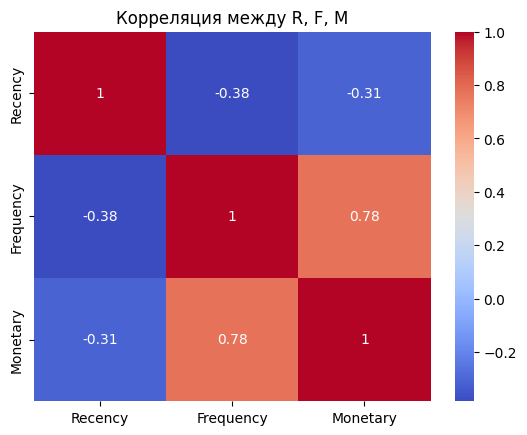

In [117]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_filtered[['Recency','Frequency','Monetary']])

# Корреляционная матрица RFM
corr_matrix = rfm_filtered[['Recency','Frequency','Monetary']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Корреляция между R, F, M")
plt.show()

## Моделирование.

### a

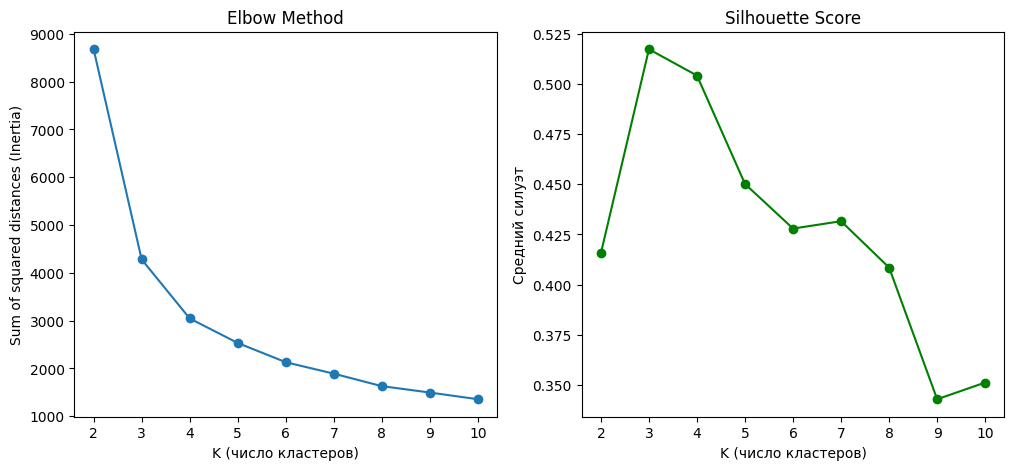

Лучший K по силуэту: 3 с оценкой 0.517


In [118]:

Ks = range(2, 11)
inertias = []
sil_scores = []
for k in Ks:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled) # обучение модели на стандартизированных данных
    inertias.append(kmeans.inertia_)
    # Оценка качества кластеризации силуэтом:
    labels = kmeans.labels_
    sil_scores.append(silhouette_score(rfm_scaled, labels))
# Визуализация метрики локтя и силуэта
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(list(Ks), inertias, marker='o')
plt.title("Elbow Method")
plt.xlabel("K (число кластеров)")
plt.ylabel("Sum of squared distances (Inertia)")
plt.subplot(1,2,2)
plt.plot(list(Ks), sil_scores, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("K (число кластеров)")
plt.ylabel("Средний силуэт")
plt.show()
# Найдем максимальный силуэт и соответствующий K
best_k = Ks[np.argmax(sil_scores)]
print("Лучший K по силуэту:", best_k, "с оценкой", round(max(sil_scores), 3))

Но мы возьмем k = 4. Для него силует отличается не сильно, а инерция ощутимо меньше.

In [119]:
optimal_k = 4

### Применим K-средних с оптимальным k.


In [120]:
kmeans_model = KMeans(n_clusters=optimal_k, init='k-means++', random_state=random_state)
cluster_labels = kmeans_model.fit_predict(rfm_scaled)
# Добавим метки кластеров в таблицу rfm_filtered
rfm_filtered['Cluster'] = cluster_labels
# Посмотрим, сколько клиентов в каждом кластерe
print("Распределение количества клиентов по кластерам:")
print(rfm_filtered['Cluster'].value_counts())

Распределение количества клиентов по кластерам:
Cluster
1    2400
2    1025
0     713
3     141
Name: count, dtype: int64


### Альтернативные алгоритмы кластеризации (DBSCAN, Hierarchical, GMM,Spectral)


#### DBSCAN



In [121]:
from sklearn.cluster import DBSCAN
# Настройка DBSCAN
# eps - радиус для соседей, min_samples - мин. точек для формирования кластера
dbscan = DBSCAN(eps=0.5, min_samples=5) # начальные значения, нужно подбирать
dbscan_labels = dbscan.fit_predict(rfm_scaled)
n_clusters_dbscan = len(set(dbscan_labels) - {-1})
print("DBSCAN нашел кластеров (не считая шум):", n_clusters_dbscan)
print("Шумовых точек (отмечено -1):", list(dbscan_labels).count(-1))


DBSCAN нашел кластеров (не считая шум): 3
Шумовых точек (отмечено -1): 91


#### Иерархическая кластеризация



In [122]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
agg_labels = agg.fit_predict(rfm_scaled)
print("Agglomerative кластеры распределение:")
print(pd.Series(agg_labels).value_counts())


Agglomerative кластеры распределение:
1    2070
2    1248
3     667
0     294
Name: count, dtype: int64


In [123]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Возьмем случайно 100 клиентов для примера дендрограммы
sample_index = np.random.choice(rfm_filtered.index, size=100, replace=False)
sample_data = rfm_scaled[sample_index]
linked = linkage(sample_data, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top')
plt.title("Dendrogram (sample of 100 customers)")
plt.show()


IndexError: index 4324 is out of bounds for axis 0 with size 4279

#### Gaussian Mixture (EM)

In [ ]:
from sklearn.mixture import GaussianMixture
best_gmm_k = None
best_gmm_score = -1
for k in Ks:
    gmm = GaussianMixture(n_components=k, random_state=random_state)
    labels = gmm.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    if score > best_gmm_score:
        best_gmm_score = score
        best_gmm_k = k
print("Лучшее число кластеров для GMM по силуэту:", best_gmm_k, "силуэт:",round(best_gmm_score, 3))
# Получим метки кластеров для этого лучшего K
gmm_model = GaussianMixture(n_components=best_gmm_k, random_state=42)
gmm_labels = gmm_model.fit_predict(rfm_scaled)

Лучшее число кластеров для GMM по силуэту: 2 силуэт: 0.391


#### Spectral Clustering

In [ ]:
from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(n_clusters=optimal_k, affinity='rbf', assign_labels='kmeans',random_state=random_state)
spectral_labels = spectral.fit_predict(rfm_scaled)
print("Spectral Clustering метки кластеров (первые 20):", spectral_labels[:20])
print("Распределение по кластерам Spectral:")
print(pd.Series(spectral_labels).value_counts())

Spectral Clustering метки кластеров (первые 20): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Распределение по кластерам Spectral:
0    4226
3      45
2       6
1       2
Name: count, dtype: int64


## Визуализация данных

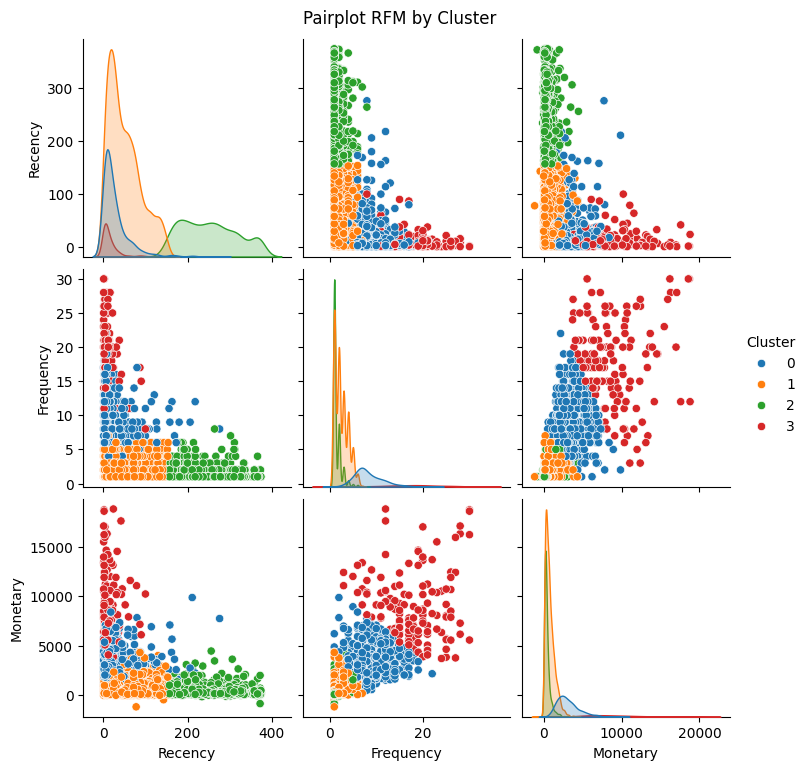

In [ ]:
sns.pairplot(rfm_filtered, vars=['Recency','Frequency','Monetary'], hue='Cluster', palette='tab10')
plt.suptitle("Pairplot RFM by Cluster", y=1.02)
plt.show()

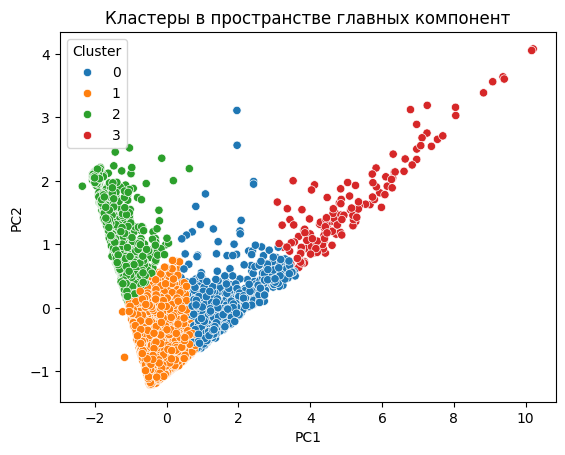

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)
# DataFrame для удобства
pca_df = pd.DataFrame(rfm_pca, columns=['PC1','PC2'], index=rfm_filtered.index)
pca_df['Cluster'] = rfm_filtered['Cluster']
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10')
plt.title("Кластеры в пространстве главных компонент")
plt.show()

c:\Users\nikit\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\nikit\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


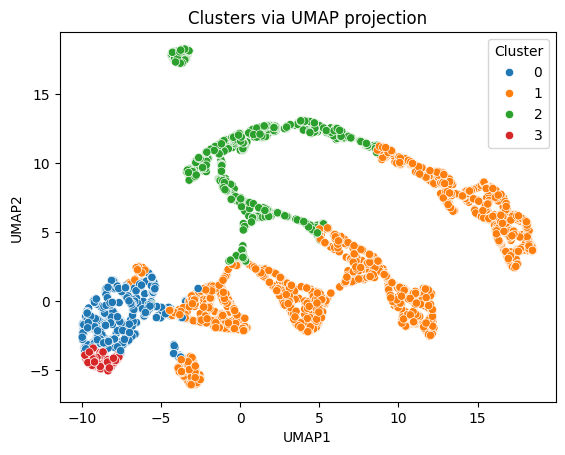

In [ ]:

import umap
# Обучаем UMAP на стандартизированных данных
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=random_state)
rfm_umap = reducer.fit_transform(rfm_scaled)
umap_df = pd.DataFrame(rfm_umap, columns=['UMAP1','UMAP2'], index=rfm_filtered.index)
umap_df['Cluster'] = rfm_filtered['Cluster']
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='Cluster', palette='tab10')
plt.title("Clusters via UMAP projection")
plt.show()

In [127]:
cluster_summary = rfm_filtered.groupby('Cluster').agg({
'Recency': 'mean',
'Frequency': 'mean',
'Monetary': 'mean',
'CustomerID': 'count' # число клиентов в кластере
}).rename(columns={'CustomerID': 'NumCustomers'})
cluster_summary = cluster_summary.round(1)
cluster_summary

,Recency,Frequency,Monetary,NumCustomers
Cluster,,,,
0,27.5,8.3,3090.9,713
1,50.2,2.5,752.9,2400
2,252.0,1.5,415.0,1025
3,14.4,17.9,8923.9,141


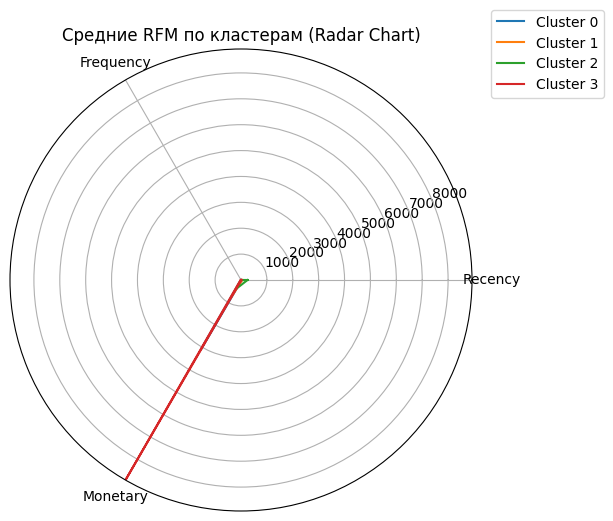

In [128]:
categories = ['Recency','Frequency','Monetary']
num_vars = len(categories)
# Угол для каждой категории в радианах
angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
angles += [angles[0]] # замыкаем круг
# Подготовка полотна
plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
# Чертим одну окружность для максимального значения (можно взять максимумы из cluster_summary)
max_values = cluster_summary[categories].max().values
ax.set_ylim(0, max(max_values)) # радиальная шкала от 0 до максимума среди средних
# Подписи осей по кругу
plt.xticks(angles[:-1], categories)
# Для каждого кластера строим линию
for cluster, row in cluster_summary.iterrows():
    values = row[categories].tolist()
    values += [values[0]] # повторяем первый показатель в конец для замыкания
    ax.plot(angles, values, label=f'Cluster {cluster}')
    ax.fill(angles, values, alpha=0.1)
plt.title("Средние RFM по кластерам (Radar Chart)")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()
